# Clustering comparison

This notebook compares two clustering methods:
- fastclust: a star-shape algorithm that selects a set prototypes from starting structures, and creates clusters with all distances of each member to its central element (prototype) below a given threshold.[see https://hal.archives-ouvertes.fr/hal-03540927/]
- radius: a hierarchical ascendant clustering with linkage function as the radius of the smallest enclosing ball. The prototypes are the centers of the balls (and not a subset of the initial structures).[see https://hal.archives-ouvertes.fr/hal-03651323]

In [30]:
first_clust_1A = {'AAA': 2589, 'AAC': 2063, 'ACA': 1810, 'ACC': 1781, 'CAA': 2154, 'CAC': 1545, 'CCA': 1934, 'CCC': 2515}
sec_clust_1A = {'AAA': 1022, 'AAC': 740, 'ACA': 672, 'ACC': 674, 'CAA': 798, 'CAC': 585, 'CCA': 727, 'CCC': 891}
first_clust_3A = {'AAA': 341, 'AAC': 282, 'ACA': 260, 'ACC': 289, 'CAA': 264, 'CAC': 207, 'CCA': 231, 'CCC': 258}
sec_clust_3A = {'AAA': 392, 'AAC': 272, 'ACA': 245, 'ACC': 263, 'CAA': 314, 'CAC': 189, 'CCA': 271, 'CCC': 260}

## Number of clusters at 1A RMSD

In [31]:
print("Ratio from first on second:")
for motif in first_clust_1A.keys():
    print(motif + " = " + str(first_clust_1A[motif]/sec_clust_1A[motif]))

Ratio from first on second:
AAA = 2.5332681017612524
AAC = 2.787837837837838
ACA = 2.693452380952381
ACC = 2.642433234421365
CAA = 2.699248120300752
CAC = 2.641025641025641
CCA = 2.660247592847318
CCC = 2.8226711560044895


We have between 2.5 and 3 more clusters when using fastclust compared to using radius. 

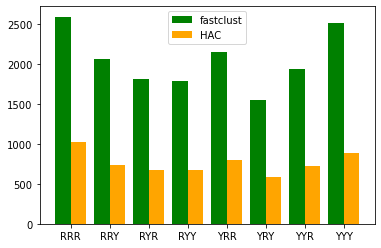

In [5]:
import matplotlib.pyplot as plt

tick = ["RRR", "RRY", "RYR", "RYY", "YRR", "YRY", "YYR", "YYY"]

plt.bar([1, 2, 3, 4, 5, 6, 7, 8], first_clust_1A.values(), 0.4, label="fastclust", color='green')
plt.bar([1.4, 2.4, 3.4, 4.4, 5.4, 6.4, 7.4, 8.4], sec_clust_1A.values(), 0.4, label="radius", color='orange')

plt.xticks([1.2, 2.2, 3.2, 4.2, 5.2, 6.2, 7.2, 8.2], tick)

plt.legend()

plt.show()

The differences of number of clusters among the purine/pyrimidine motifs remain qualitatively similar for both clustering methods.

In [7]:
from scipy.stats import ttest_rel

print(ttest_rel(list(first_clust_1A.values()), list(sec_clust_1A.values())))

Ttest_relResult(statistic=15.899436337157697, pvalue=9.44468577792314e-07)


A student test is made to compare the two numbers of clusters obtained with each clustering method. We can conclude that the HAC method creates less clusters, as the pvalue is below 0.001.

## Number of clusters at 3A RMSD

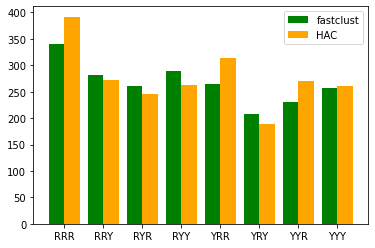

In [32]:
tick = ["RRR", "RRY", "RYR", "RYY", "YRR", "YRY", "YYR", "YYY"]

plt.bar([1, 2, 3, 4, 5, 6, 7, 8], first_clust_3A.values(), 0.4, label="fastclust", color='green')
plt.bar([1.4, 2.4, 3.4, 4.4, 5.4, 6.4, 7.4, 8.4], sec_clust_3A.values(), 0.4, label="radius", color='orange')

plt.xticks([1.2, 2.2, 3.2, 4.2, 5.2, 6.2, 7.2, 8.2], tick)

plt.legend()

plt.show()

## Conformations (1A RMSD) induced by protein-binding

A deeper comparison will require the user to create the clusters using both methods.The first clustering folder is created with the `data_protnaff.ipynb` notebook. We will create the second one here (**pay attention, it will take several hours !**)

In [ ]:
!mv $PROTNAFF/data_paper/trilib $PROTNAFF/data_paper/trilib_fast
!cd $PROTNAFF/data_paper && bash $PROTNAFF/create_frag_library.sh -a rna
!mv $PROTNAFF/data_paper/trilib $PROTNAFF/data_paper/trilib_radius
!mv $PROTNAFF/data_paper/trilib_fast $PROTNAFF/data_paper/trilib

In [8]:
def parsing_fragments(fragments, structures, cutoff):
    """
    This function will parse the fragments dictionnary to extract information about clusters, 
    then it will parse those clusters to extract their properties.
    results are given for each cluster
    res_bis is a sum of information by cluster
    """
    results = {"AAA":{}, "AAC":{}, "ACA":{}, "ACC":{}, "CAA":{}, "CAC":{}, "CCA":{}, "CCC":{}}
    res_bis = {"AAA":{}, "AAC":{}, "ACA":{}, "ACC":{}, "CAA":{}, "CAC":{}, "CCA":{}, "CCC":{}}
    for key in results.keys():
        for key2 in fragments[key].keys():
            model = "model_" + str(fragments[key][key2]["model"])
            chain = "chain_" + str(fragments[key][key2]["chain"])
            contact = False
            interface = set()
            for nucl in structures[fragments[key][key2]['structure']]["interface_protein"]["model_1"][chain].keys():
                interface.add(nucl.split('_')[1])
            ss=True
            ds=0
            for nucl in fragments[key][key2]['indices']:
                if str(nucl) in interface:
                    contact = True
                if structures[fragments[key][key2]['structure']]["ss"][chain]["res_"+str(nucl)][0]=="D":
                    ss=False
                    ds+=1
            if fragments[key][key2][cutoff] not in results[key].keys():
                results[key][fragments[key][key2][cutoff]] = {"contact_ss":0, "contact_ds":0, "contact_mixte":0, "nocontact_ss":0, "nocontact_ds":0, "nocontact_mixte":0}
            if contact:
                if ss:
                    results[key][fragments[key][key2][cutoff]]["contact_ss"] += 1
                elif ds == 3:
                    results[key][fragments[key][key2][cutoff]]["contact_ds"] += 1
                else:
                    results[key][fragments[key][key2][cutoff]]["contact_mixte"] += 1
            else:
                if ss:
                    results[key][fragments[key][key2][cutoff]]["nocontact_ss"] += 1
                elif ds == 3:
                    results[key][fragments[key][key2][cutoff]]["nocontact_ds"] += 1
                else:
                    results[key][fragments[key][key2][cutoff]]["nocontact_mixte"] += 1
        con_ss = 0
        sum_con_ss = 0
        con_ds = 0
        sum_con_ds = 0
        con_mixte = 0
        sum_con_mixte = 0
        nocon_ss = 0
        sum_nocon_ss = 0
        nocon_ds = 0
        sum_nocon_ds = 0
        nocon_mixte = 0
        sum_nocon_mixte = 0
        mixte_ss = 0
        sum_mixte_ss = 0
        mixte_ds = 0
        sum_mixte_ds = 0
        mixte_mixte = 0
        sum_mixte_mixte=0
        for clust in results[key].keys():
            #if there is at least 3 fragments in the cluster:
            if results[key][clust]["contact_ss"] + results[key][clust]["contact_ds"] + results[key][clust]["contact_mixte"] + results[key][clust]["nocontact_ss"] + results[key][clust]["nocontact_ds"] + results[key][clust]["nocontact_mixte"] > 2:
                if results[key][clust]["nocontact_mixte"] == 0 and results[key][clust]["nocontact_ds"] == 0 and results[key][clust]["nocontact_ss"] == 0:
                    if results[key][clust]["contact_mixte"] > 0:
                        con_mixte += 1
                        sum_con_mixte += results[key][clust]["contact_ss"] + results[key][clust]["contact_ds"] + results[key][clust]["contact_mixte"]
                    else:
                        if results[key][clust]["contact_ds"] == 0:
                            con_ss += 1
                            sum_con_ss += results[key][clust]["contact_ss"]
                        else:
                            con_ds += 1
                            sum_con_ds += results[key][clust]["contact_ds"]
                elif results[key][clust]["contact_ss"] == 0 and results[key][clust]["contact_ds"] == 0 and results[key][clust]["contact_mixte"] == 0:
                    if results[key][clust]["nocontact_mixte"] > 0:
                        nocon_mixte += 1
                        sum_nocon_mixte += results[key][clust]["nocontact_ss"] + results[key][clust]["nocontact_ds"] + results[key][clust]["nocontact_mixte"]
                    else:
                        if results[key][clust]["nocontact_ss"] == 0:
                            nocon_ds += 1
                            sum_nocon_ds += results[key][clust]["nocontact_ds"]
                        else:
                            nocon_ss += 1
                            sum_nocon_ss += results[key][clust]["nocontact_ss"]
                else:
                    if results[key][clust]["nocontact_mixte"] > 0 or results[key][clust]["contact_mixte"] > 0 or (results[key][clust]["nocontact_ss"] != 0 and results[key][clust]["nocontact_ds"] !=0) or (results[key][clust]["contact_ss"] != 0 or results[key][clust]["contact_ds"] !=0):
                        mixte_mixte += 1
                        sum_mixte_mixte += results[key][clust]["nocontact_ss"] + results[key][clust]["nocontact_ds"] + results[key][clust]["nocontact_mixte"] + results[key][clust]["contact_ss"] + results[key][clust]["contact_ds"] + results[key][clust]["contact_mixte"]
                    else:
                        if results[key][clust]["contact_ss"] == 0 and results[key][clust]["nocontact_ss"] == 0:
                            mixte_ds += 1
                            sum_mixte_ds += results[key][clust]["nocontact_ds"] + results[key][clust]["contact_ds"]
                        else:
                            mixte_ss += 1
                            sum_mixte_ss += results[key][clust]["contact_ss"] + results[key][clust]["nocontact_ss"]             

        res_bis[key] = {"contact_ss":con_ss, "contact_ds":con_ds, "contact_mixte":con_mixte, "nocontact_ss":nocon_ss, "nocontact_ds":nocon_ds, "nocontact_mixte":nocon_mixte, "mixte_ss":mixte_ss, "mixte_ds":mixte_ds, "mixte_mixte":mixte_mixte, \
                       "sum_contact_ss":sum_con_ss, "sum_contact_ds":sum_con_ds, "sum_contact_mixte":sum_con_mixte, \
                       "sum_nocontact_ss":sum_nocon_ss, "sum_nocontact_ds":sum_nocon_ds, "sum_nocontact_mixte":sum_nocon_mixte,\
                       "sum_mixte_ss":sum_mixte_ss, "sum_mixte_ds":sum_mixte_ds, "sum_mixte_mixte":sum_mixte_mixte}

    return results, res_bis

In [22]:
import os
import json
import numpy as np

#The graphics libraries
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

folder = "./data_paper"
folder_fastclust = "./data_paper/trilib"
folder_radius = "./data_paper/trilib_radius"

structures = json.load(open("{}/structures.json".format(folder)))
fragments_fastclust = json.load(open("{}/fragments_clust.json".format(folder)))
fragments_radius = json.load(open("{}/fragments_clust_radius.json".format(folder)))

In [33]:
results_1A, res_cluster_1A = parsing_fragments(fragments_fastclust, structures, 'clust1.0')
results_1A_radius, res_cluster_1A_radius = parsing_fragments(fragments_radius, structures, 'clust1.0')
results_3A, res_cluster_3A = parsing_fragments(fragments_fastclust, structures, 'clust3.0')
results_3A_radius, res_cluster_3A_radius = parsing_fragments(fragments_radius, structures, 'clust3.0')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


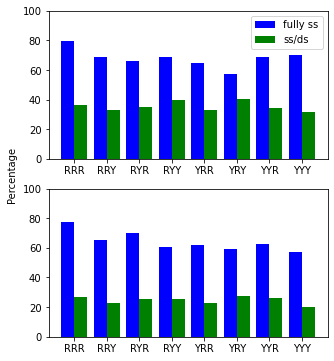

In [34]:
hist={"AAA":[], "AAC":[], "ACA":[], "ACC":[], "CAA":[], "CAC":[], "CCA":[], "CCC":[]}
tick = ["RRR", "RRY", "RYR", "RYY", "YRR", "YRY", "YYR", "YYY"]

for key in res_cluster_1A.keys():
    if (res_cluster_1A[key]["contact_ss"]+res_cluster_1A[key]["mixte_ss"]+res_cluster_1A[key]["nocontact_ss"]) != 0:
        hist[key].append(round((100*(res_cluster_1A[key]["contact_ss"]/(res_cluster_1A[key]["contact_ss"]+res_cluster_1A[key]["mixte_ss"]+res_cluster_1A[key]["nocontact_ss"]))),2))
    else:
        hist[key].append(0)
    if (res_cluster_1A[key]["contact_mixte"]+res_cluster_1A[key]["mixte_mixte"]+res_cluster_1A[key]["nocontact_mixte"]+res_cluster_1A[key]["contact_ds"]+res_cluster_1A[key]["mixte_ds"]+res_cluster_1A[key]["nocontact_ds"]) != 0:
        hist[key].append(round((100*((res_cluster_1A[key]["contact_mixte"]+res_cluster_1A[key]["contact_ds"])/(res_cluster_1A[key]["contact_mixte"]+res_cluster_1A[key]["mixte_mixte"]+res_cluster_1A[key]["nocontact_mixte"]+res_cluster_1A[key]["contact_ds"]+res_cluster_1A[key]["mixte_ds"]+res_cluster_1A[key]["nocontact_ds"]))),2))
    else:
        hist[key].append(0)
        
a = [row[0] for row in list(hist.values())]
b = [row[1] for row in list(hist.values())]

hist_1A_radius={"AAA":[], "AAC":[], "ACA":[], "ACC":[], "CAA":[], "CAC":[], "CCA":[], "CCC":[]}

for key in res_cluster_1A_radius.keys():
    if (res_cluster_1A_radius[key]["contact_ss"]+res_cluster_1A_radius[key]["mixte_ss"]+res_cluster_1A_radius[key]["nocontact_ss"]) != 0:
        hist_1A_radius[key].append(round((100*(res_cluster_1A_radius[key]["contact_ss"]/(res_cluster_1A_radius[key]["contact_ss"]+res_cluster_1A_radius[key]["mixte_ss"]+res_cluster_1A_radius[key]["nocontact_ss"]))),2))
    else:
        hist_1A_radius[key].append(0)
    if (res_cluster_1A_radius[key]["contact_mixte"]+res_cluster_1A_radius[key]["mixte_mixte"]+res_cluster_1A_radius[key]["nocontact_mixte"]+res_cluster_1A_radius[key]["contact_ds"]+res_cluster_1A_radius[key]["mixte_ds"]+res_cluster_1A_radius[key]["nocontact_ds"]) != 0:
        hist_1A_radius[key].append(round((100*((res_cluster_1A_radius[key]["contact_mixte"]+res_cluster_1A_radius[key]["contact_ds"])/(res_cluster_1A_radius[key]["contact_mixte"]+res_cluster_1A_radius[key]["mixte_mixte"]+res_cluster_1A_radius[key]["nocontact_mixte"]+res_cluster_1A_radius[key]["contact_ds"]+res_cluster_1A_radius[key]["mixte_ds"]+res_cluster_1A_radius[key]["nocontact_ds"]))),2))
    else:
        hist_1A_radius[key].append(0)
        
a_1A_radius = [row[0] for row in list(hist_1A_radius.values())]
b_1A_radius = [row[1] for row in list(hist_1A_radius.values())]

fig4 = plt.figure(figsize=(5, 6))
gs = gridspec.GridSpec(2, 1)

x1= [i-0.2 for i in range(8)]
x2= [i+0.2 for i in range(8)]

ax1 = plt.subplot(gs[0, 0])
ax1.bar(x1, a, width=0.4, color='b', align='center', label="fully ss")
ax1.bar(x2, b, width=0.4, color='g', align='center', label="ss/ds")
ax1.xaxis.set_ticks(range(8))
ax1.xaxis.set_ticklabels(tick, color="black")
ax1.set_ylim(0,100)

ax2 = plt.subplot(gs[1, 0])
ax2.bar(x1, a_1A_radius, width=0.4, color='b', align='center', label="fully ss")
ax2.bar(x2, b_1A_radius, width=0.4, color='g', align='center', label="ss/ds")
ax2.xaxis.set_ticks(range(8))
ax2.xaxis.set_ticklabels(tick, color="black")
ax2.set_ylim(0,100)

fig4.text(0.01, 0.5, 'Percentage', va='center', rotation='vertical')
ax1.legend(loc="upper right")
#plt.figure(figsize=(4,6))
plt.savefig("fig5.eps", facecolor="w", dpi=600, format='eps')
plt.show()

 Percentage of the either purely single-stranded or mixed clusters (1A) that are induced by the contact to the protein. The upper panel corresponds to the clusters obtained by fastclust, and the lower panel by radius..

## Conformations (3A RMSD) induced by protein-binding

{'AAA': {'contact_ss': 0, 'contact_ds': 0, 'contact_mixte': 0, 'nocontact_ss': 0, 'nocontact_ds': 0, 'nocontact_mixte': 0, 'mixte_ss': 0, 'mixte_ds': 0, 'mixte_mixte': 1, 'sum_contact_ss': 0, 'sum_contact_ds': 0, 'sum_contact_mixte': 0, 'sum_nocontact_ss': 0, 'sum_nocontact_ds': 0, 'sum_nocontact_mixte': 0, 'sum_mixte_ss': 0, 'sum_mixte_ds': 0, 'sum_mixte_mixte': 17540}, 'AAC': {'contact_ss': 0, 'contact_ds': 0, 'contact_mixte': 0, 'nocontact_ss': 0, 'nocontact_ds': 0, 'nocontact_mixte': 0, 'mixte_ss': 0, 'mixte_ds': 0, 'mixte_mixte': 1, 'sum_contact_ss': 0, 'sum_contact_ds': 0, 'sum_contact_mixte': 0, 'sum_nocontact_ss': 0, 'sum_nocontact_ds': 0, 'sum_nocontact_mixte': 0, 'sum_mixte_ss': 0, 'sum_mixte_ds': 0, 'sum_mixte_mixte': 14388}, 'ACA': {'contact_ss': 0, 'contact_ds': 0, 'contact_mixte': 0, 'nocontact_ss': 0, 'nocontact_ds': 0, 'nocontact_mixte': 0, 'mixte_ss': 0, 'mixte_ds': 0, 'mixte_mixte': 1, 'sum_contact_ss': 0, 'sum_contact_ds': 0, 'sum_contact_mixte': 0, 'sum_nocontact_ss

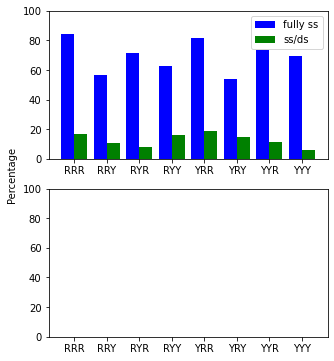

In [40]:
hist={"AAA":[], "AAC":[], "ACA":[], "ACC":[], "CAA":[], "CAC":[], "CCA":[], "CCC":[]}
tick = ["RRR", "RRY", "RYR", "RYY", "YRR", "YRY", "YYR", "YYY"]

for key in res_cluster_3A.keys():
    if (res_cluster_3A[key]["contact_ss"]+res_cluster_3A[key]["mixte_ss"]+res_cluster_3A[key]["nocontact_ss"]) != 0:
        hist[key].append(round((100*(res_cluster_3A[key]["contact_ss"]/(res_cluster_3A[key]["contact_ss"]+res_cluster_3A[key]["mixte_ss"]+res_cluster_3A[key]["nocontact_ss"]))),2))
    else:
        hist[key].append(0)
    if (res_cluster_3A[key]["contact_mixte"]+res_cluster_3A[key]["mixte_mixte"]+res_cluster_3A[key]["nocontact_mixte"]+res_cluster_3A[key]["contact_ds"]+res_cluster_3A[key]["mixte_ds"]+res_cluster_3A[key]["nocontact_ds"]) != 0:
        hist[key].append(round((100*((res_cluster_3A[key]["contact_mixte"]+res_cluster_3A[key]["contact_ds"])/(res_cluster_3A[key]["contact_mixte"]+res_cluster_3A[key]["mixte_mixte"]+res_cluster_3A[key]["nocontact_mixte"]+res_cluster_3A[key]["contact_ds"]+res_cluster_3A[key]["mixte_ds"]+res_cluster_3A[key]["nocontact_ds"]))),2))
    else:
        hist[key].append(0)
        
a = [row[0] for row in list(hist.values())]
b = [row[1] for row in list(hist.values())]

hist_3A_radius={"AAA":[], "AAC":[], "ACA":[], "ACC":[], "CAA":[], "CAC":[], "CCA":[], "CCC":[]}

for key in res_cluster_3A_radius.keys():
    if (res_cluster_3A_radius[key]["contact_ss"]+res_cluster_3A_radius[key]["mixte_ss"]+res_cluster_3A_radius[key]["nocontact_ss"]) != 0:
        hist_3A_radius[key].append(round((100*(res_cluster_3A_radius[key]["contact_ss"]/(res_cluster_3A_radius[key]["contact_ss"]+res_cluster_3A_radius[key]["mixte_ss"]+res_cluster_3A_radius[key]["nocontact_ss"]))),2))
    else:
        hist_3A_radius[key].append(0)
    if (res_cluster_3A_radius[key]["contact_mixte"]+res_cluster_3A_radius[key]["mixte_mixte"]+res_cluster_3A_radius[key]["nocontact_mixte"]+res_cluster_3A_radius[key]["contact_ds"]+res_cluster_3A_radius[key]["mixte_ds"]+res_cluster_3A_radius[key]["nocontact_ds"]) != 0:
        hist_3A_radius[key].append(round((100*((res_cluster_3A_radius[key]["contact_mixte"]+res_cluster_3A_radius[key]["contact_ds"])/(res_cluster_3A_radius[key]["contact_mixte"]+res_cluster_3A_radius[key]["mixte_mixte"]+res_cluster_3A_radius[key]["nocontact_mixte"]+res_cluster_3A_radius[key]["contact_ds"]+res_cluster_3A_radius[key]["mixte_ds"]+res_cluster_3A_radius[key]["nocontact_ds"]))),2))
    else:
        hist_1A_radius[key].append(0)
        
a_3A_radius = [row[0] for row in list(hist_3A_radius.values())]
b_3A_radius = [row[1] for row in list(hist_3A_radius.values())]
print(res_cluster_3A_radius)
fig4 = plt.figure(figsize=(5, 6))
gs = gridspec.GridSpec(2, 1)

x1= [i-0.2 for i in range(8)]
x2= [i+0.2 for i in range(8)]

ax1 = plt.subplot(gs[0, 0])
ax1.bar(x1, a, width=0.4, color='b', align='center', label="fully ss")
ax1.bar(x2, b, width=0.4, color='g', align='center', label="ss/ds")
ax1.xaxis.set_ticks(range(8))
ax1.xaxis.set_ticklabels(tick, color="black")
ax1.set_ylim(0,100)

ax2 = plt.subplot(gs[1, 0])
ax2.bar(x1, a_3A_radius, width=0.4, color='b', align='center', label="fully ss")
ax2.bar(x2, b_3A_radius, width=0.4, color='g', align='center', label="ss/ds")
ax2.xaxis.set_ticks(range(8))
ax2.xaxis.set_ticklabels(tick, color="black")
ax2.set_ylim(0,100)

fig4.text(0.01, 0.5, 'Percentage', va='center', rotation='vertical')
ax1.legend(loc="upper right")
#plt.figure(figsize=(4,6))
#plt.savefig("fig5.eps", facecolor="w", dpi=600, format='eps')
plt.show()

 Percentage of the either purely single-stranded or mixed clusters (3A) that are induced by the contact to the protein. The upper panel corresponds to the clusters obtained by fastclust, and the lower panel by radius..

## Number of clusters with less than 3 elements

In [28]:
print('motif | Nb clusters | Nb clusters with n<3 | Nb clusters with n>=3')
print('Fastclust')
for motif in results_1A.keys():
    res = 0
    i = 0
    for clust in results_1A[motif].values():
        i += 1
        if clust['contact_ss'] + clust['contact_ds'] + clust['contact_mixte'] + clust['nocontact_ss'] + clust['nocontact_ds'] + clust['nocontact_mixte'] < 3:
            res +=1
    print(motif, i, res, i-res)
 
print()
print('Radius')
for motif in results_1A_radius.keys():
    res = 0
    i = 0
    for clust in results_1A_radius[motif].values():
        i += 1
        if clust['contact_ss'] + clust['contact_ds'] + clust['contact_mixte'] + clust['nocontact_ss'] + clust['nocontact_ds'] + clust['nocontact_mixte'] < 3:
            res +=1
    print(motif, i, res, i- res)

AAA 2590 1930 660
AAC 2064 1571 493
ACA 1811 1373 438
ACC 1782 1441 341
CAA 2155 1597 558
CAC 1546 1184 362
CCA 1935 1547 388
CCC 2516 2042 474

AAA 1023 403 620
AAC 741 295 446
ACA 673 266 407
ACC 675 303 372
CAA 799 314 485
CAC 586 229 357
CCA 728 322 406
CCC 892 401 491
